## Let's try RNN

In [65]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import random

random.seed(0)
torch.manual_seed(0)


In [66]:
DATA_DIR = "./generated_data"
CSV_NAME = "generated_data_fbcampus_2"

In [67]:
# change names
# for csv_path in os.listdir(DATA_DIR):
#     my_df = pd.read_csv(os.path.join(DATA_DIR, csv_path))
#     alpha = my_df["alpha"].unique()
#     print(alpha)
    # if csv_path.endswith(".csv"):
        # os.rename(os.path.join(DATA_DIR, csv_path), os.path.join(DATA_DIR, CSV_NAME))

## Merge CSVs

In [68]:
df = pd.read_csv(os.path.join(DATA_DIR, f'{CSV_NAME}.csv'))

df = df.dropna(axis=1) # to prevent nan in model output
df.head()


,noisy_motion_x,noisy_motion_y,noisy_motion_theta,noisy_motion_cov_xx,noisy_motion_cov_xy,noisy_motion_cov_xtheta,noisy_motion_cov_yy,noisy_motion_cov_ytheta,noisy_motion_cov_thetatheta,kalman_prediction_x,...,lidar_cov_xx,lidar_cov_xy,lidar_cov_xtheta,lidar_cov_yy,lidar_cov_ytheta,lidar_cov_thetatheta,ground_truth_x,ground_truth_y,ground_truth_theta,alpha
0,-1.836162e-06,0.000011,0.000085,8.273241e-12,-4.986194e-11,-3.843438e-10,3.005126e-10,2.316399e-09,1.785517e-08,-0.000046,...,0.000002,3.603949e-07,0.0,0.000004,0.0,3.683649e-08,-0.000089,-0.000089,0.003760,8
1,8.146158e-07,-0.000005,-0.000038,8.284437e-12,-4.990645e-11,-3.846952e-10,3.006426e-10,2.317451e-09,1.786367e-08,-0.000046,...,0.000002,4.694778e-07,0.0,0.000004,0.0,4.347377e-08,-0.000089,-0.000089,0.003794,8
2,2.668217e-07,-0.000002,-0.000012,8.295645e-12,-4.995101e-11,-3.850469e-10,3.007726e-10,2.318503e-09,1.787217e-08,-0.000046,...,0.000002,2.216968e-07,0.0,0.000004,0.0,3.833651e-08,-0.000090,-0.000090,0.003827,8
3,-4.128545e-06,0.000025,0.000192,8.306869e-12,-4.999559e-11,-3.853990e-10,3.009027e-10,2.319556e-09,1.788067e-08,-0.000051,...,0.000002,3.671549e-07,0.0,0.000003,0.0,3.762879e-08,-0.000091,-0.000091,0.003861,8
4,2.913300e-06,-0.000018,-0.000135,8.318107e-12,-5.004022e-11,-3.857513e-10,3.010328e-10,2.320610e-09,1.788918e-08,-0.000051,...,0.000002,2.164658e-07,0.0,0.000004,0.0,4.273847e-08,-0.000092,-0.000092,0.003894,8


In [69]:
# for i in df.columns:
#     print(i)
df.columns

Index(['noisy_motion_x', 'noisy_motion_y', 'noisy_motion_theta',
       'noisy_motion_cov_xx', 'noisy_motion_cov_xy', 'noisy_motion_cov_xtheta',
       'noisy_motion_cov_yy', 'noisy_motion_cov_ytheta',
       'noisy_motion_cov_thetatheta', 'kalman_prediction_x',
       'kalman_prediction_y', 'kalman_prediction_theta', 'lidar_x', 'lidar_y',
       'lidar_theta', 'lidar_cov_xx', 'lidar_cov_xy', 'lidar_cov_xtheta',
       'lidar_cov_yy', 'lidar_cov_ytheta', 'lidar_cov_thetatheta',
       'ground_truth_x', 'ground_truth_y', 'ground_truth_theta', 'alpha'],
      dtype='object')

## Columns for 2D case
- Kalman Predictions:
    - kalman_prediction_x
    - kalman_prediction_y
    - kalman_prediction_theta

- Ground Truth:
    - ground_truth_x
    - ground_truth_y
    - ground_truth_theta

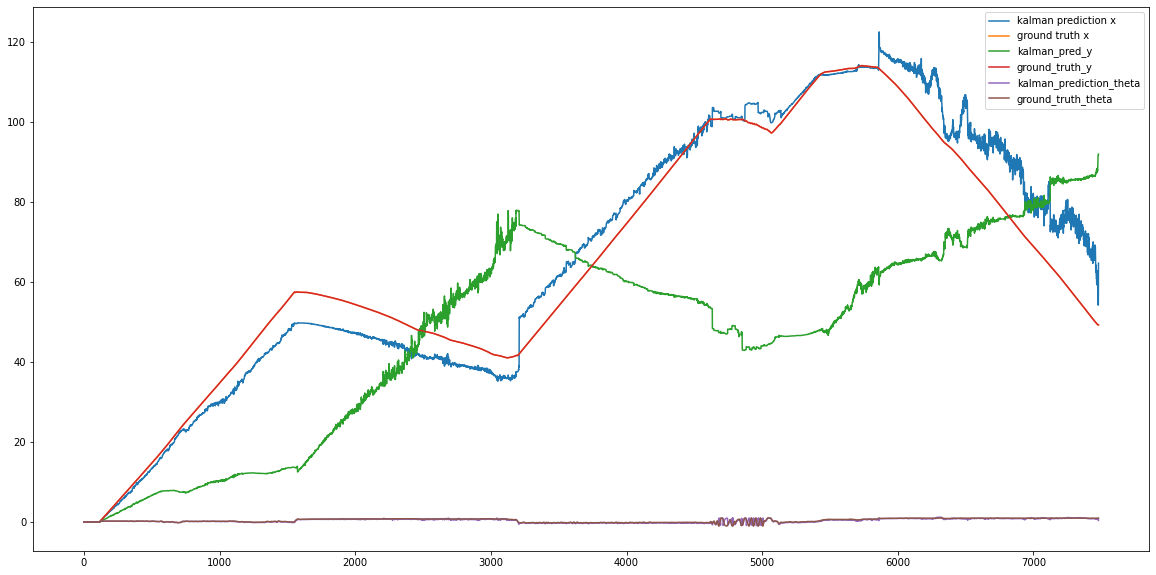

In [70]:
# Split
# train_df = df.sample(frac=0.8, random_state=0)
# test_df = df.drop(df.index)


# sanity checks
# kf_pred = torch.tensor(df['kalman prediction'].to_list()).reshape(-1, 1)
# gt = torch.tensor(df['ground truth'].to_list()).reshape(-1, 1)

split = -1


plt.figure(figsize=(20, 10))
plt.plot(df['kalman_prediction_x'].to_list()[:split])
plt.plot(df['ground_truth_x'].to_list()[:split])

plt.plot(df['kalman_prediction_y'].to_list()[:split])
plt.plot(df['ground_truth_y'].to_list()[:split])


plt.plot(df['kalman_prediction_theta'].to_list()[:split])
plt.plot(df['ground_truth_theta'].to_list()[:split])


plt.legend(['kalman prediction x', 'ground truth x', "kalman_pred_y","ground_truth_y", "kalman_prediction_theta",  "ground_truth_theta"])
plt.show()

In [71]:
# df[df.isna().values]

## Model

In [72]:
# Define the RNN model
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleRNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    # def forward(self, x, h0):
    def forward(self, x):
        # h0 from the last batch

        # print(x.shape)
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        # print(h0.shape, torch.zeros(1, x.size(0), self.hidden_size).to(x.device).shape)
        out, _ = self.rnn(x, h0)
        if out.isnan().any():
            print("NAN:", out)
        fc_out = self.fc(out[:, -1, :]) # taking only the last hidden layer output
        # print(fc_out.shape, out.shape)
        if out.isnan().any():
            print("NAN: Second: ", out)
        return fc_out, out

## Reshape csv as per the seq length and batch size

In [73]:
def get_input_data(df, seq_len, batch_size, num_batches):

       labels = df[["ground_truth_x", "ground_truth_y", "ground_truth_theta" ]].to_numpy()
       kalman_pred = df[["kalman_prediction_x", "kalman_prediction_y", "kalman_prediction_theta"]].to_numpy() # used for comparison

       input_data_df = df[
              ['noisy_motion_x', 'noisy_motion_y', 'noisy_motion_theta',
              'noisy_motion_cov_xx', 'noisy_motion_cov_xy', 'noisy_motion_cov_xtheta',
              'noisy_motion_cov_yy', 'noisy_motion_cov_ytheta',
              'noisy_motion_cov_thetatheta','lidar_x', 'lidar_y',
              'lidar_theta', 'lidar_cov_xx', 'lidar_cov_xy', 'lidar_cov_xtheta',
              'lidar_cov_yy', 'lidar_cov_ytheta', 'lidar_cov_thetatheta']
       ].to_numpy()

       # input_data = input_data_df[:num_batches * batch_size]
       input_data = input_data_df.copy()

       # output_data = labels[:num_batches * batch_size]
       output_data = labels.copy()



       new_input_data = []
       new_output_data = []
       new_kp_data = []

       for i in range(len(input_data) - seq_len):
              new_input_data.append(input_data[i:i+seq_len])
              new_output_data.append(output_data[i + seq_len -1])
              new_kp_data.append(kalman_pred[i + seq_len -1])


       new_input_data = np.array(new_input_data[:num_batches* batch_size]) # drop the last batch
       new_output_data = np.array(new_output_data[:num_batches* batch_size]) # drop the last batch
       new_kp_data = np.array(new_kp_data[:num_batches* batch_size]) # drop the last batch
       
       return new_input_data, new_output_data, new_kp_data


In [74]:
seq_len = 10
batch_size = 10
num_batches = (len(df) - seq_len) // (batch_size)

new_input_data, new_output_data, kalman_pred_data =  get_input_data(df, seq_len = seq_len, batch_size = batch_size, num_batches = num_batches)


# new_input_data.shape == (num_batches* batch_size, seq_len, new_input_data.shape[-1])

In [75]:
new_input_data.shape, new_output_data.shape, kalman_pred_data.shape

((7470, 10, 18), (7470, 3), (7470, 3))

In [76]:
# # sanity check
print(new_input_data[0][-1], new_output_data[0].round(6))
print(df.iloc[seq_len - 1][["ground_truth_x", "ground_truth_y", "ground_truth_theta" ]].to_numpy(), new_output_data[0])
# == new_output_data[0].round(6)

# df.iloc[seq_len - 1]

[-3.84768327e-06  2.30938422e-05  1.78045739e-04  8.37450682e-12
 -5.02638937e-11 -3.87517712e-10  3.01684538e-10  2.32588615e-09
  1.79317983e-08 -4.70780981e-03 -1.31235550e-03  3.09642901e-03
  2.15874138e-06  5.28922953e-07  0.00000000e+00  3.36391258e-06
  0.00000000e+00  3.88806036e-08] [-9.500e-05 -9.500e-05  4.061e-03]
[-9.52496882e-05 -9.52496882e-05  4.06139017e-03] [-9.52496882e-05 -9.52496882e-05  4.06139017e-03]


In [77]:
# split
# train_input_data = new_input_data[:num_batches* batch_size//2]
# train_output_data = new_output_data[:num_batches* batch_size//2]
# new_input_data[:len(new_input_data)*0.8, ].shape

test_idx = random.sample(range(len(new_input_data)), k = int(len(new_input_data)*0.2))
train_idx = [i for i in range(len(new_input_data)) if i not in test_idx]

test_input = new_input_data[test_idx]
test_output = new_output_data[test_idx]

train_input = new_input_data[train_idx]
train_output = new_output_data[train_idx].reshape(-1, 3)

train_kalman_pred = kalman_pred_data[train_idx]
test_kalman_pred = kalman_pred_data[test_idx]



In [78]:
train_input.shape, train_output.shape, test_input.shape, test_output.shape, train_kalman_pred.shape, test_kalman_pred.shape

((5976, 10, 18), (5976, 3), (1494, 10, 18), (1494, 3), (5976, 3), (1494, 3))

In [79]:
# train_input.shape, train_output.shape, test_input.shape, test_output.shape

# train_input.shape, batch_size, (train_input.shape[0]//batch_size)*batch_size
# 

# get pytorch csv dataloader
train_dataset = torch.utils.data.TensorDataset(torch.from_numpy(train_input).float(), torch.from_numpy(train_output).float())
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

test_dataset = torch.utils.data.TensorDataset(torch.from_numpy(test_input).float(), torch.from_numpy(test_output).float())
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False , drop_last=True)

## Gear Up | Train | Launch

In [80]:
input_size = 18
output_size = train_output.shape[1]
hidden_size = 256
lr = 0.0001

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = SimpleRNN(input_size, hidden_size, output_size).to(device)

# Define the loss function and optimizer
criterion = nn.MSELoss()
criterion_l1 = nn.L1Loss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.99)
# lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08)
# lr_scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, 0.0001, 0.0001, 1000)


In [81]:
# Train the model
loss_cache = []


num_epochs = 100
for epoch in range(num_epochs):
    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        output, hidden_output = model(inputs)
        loss = criterion(output, targets)
        loss.backward()
        optimizer.step()
        # lr_scheduler.step()

    loss_cache.append(loss.item())
    # Print the loss after every epoch
    if epoch %5 ==0:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))



Epoch [1/100], Loss: 13.9185
Epoch [6/100], Loss: 3.3447
Epoch [11/100], Loss: 0.1340
Epoch [16/100], Loss: 0.1673
Epoch [21/100], Loss: 0.0749
Epoch [26/100], Loss: 0.2264
Epoch [31/100], Loss: 0.1549
Epoch [36/100], Loss: 0.5020
Epoch [41/100], Loss: 0.1679
Epoch [46/100], Loss: 0.1131
Epoch [51/100], Loss: 0.8093
Epoch [56/100], Loss: 2.2649
Epoch [61/100], Loss: 3.4749
Epoch [66/100], Loss: 1.0925
Epoch [71/100], Loss: 8.8838
Epoch [76/100], Loss: 7.1461
Epoch [81/100], Loss: 0.2775
Epoch [86/100], Loss: 1.6481
Epoch [91/100], Loss: 0.2362
Epoch [96/100], Loss: 3.5048


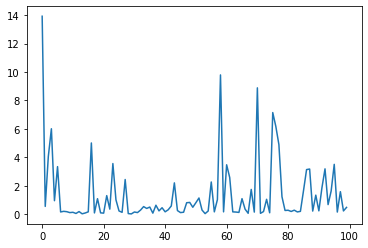

In [83]:
plt.plot(loss_cache)

## Pred

In [84]:

loss_cache = []
test_pred = []
with torch.no_grad():
    for inputs, outputs in test_loader:
        inputs = inputs.to(device)
        outputs = outputs.to(device).view(-1, 3)
        # outputs = outputs
        pred, _ = model(inputs)
        test_pred.append(pred)
        loss = criterion(pred, outputs)
        # print(loss.item())
        loss_cache.append(loss.item())

In [85]:
sum(loss_cache)

11075.78610610962

In [86]:
# Kalman filter prediction loss
loss_kp = criterion(torch.from_numpy(test_kalman_pred), torch.from_numpy(test_output))
loss_kp

tensor(361.5738, dtype=torch.float64)

In [87]:
test_output.shape, test_pred.shape
test_pred_x = test_pred[:, 0].cpu().numpy()
test_pred_y = test_pred[:, 1].cpu().numpy()
test_pred_theta = test_pred[:, 2].cpu().numpy()

test_output_x = test_output[:, 0]
test_output_y = test_output[:, 1]
test_output_theta = test_output[:, 2]

kalman_pred_x = test_kalman_pred[:, 0]
kalman_pred_y = test_kalman_pred[:, 1]
kalman_pred_theta = test_kalman_pred[:, 2]

AttributeError: 'list' object has no attribute 'shape'

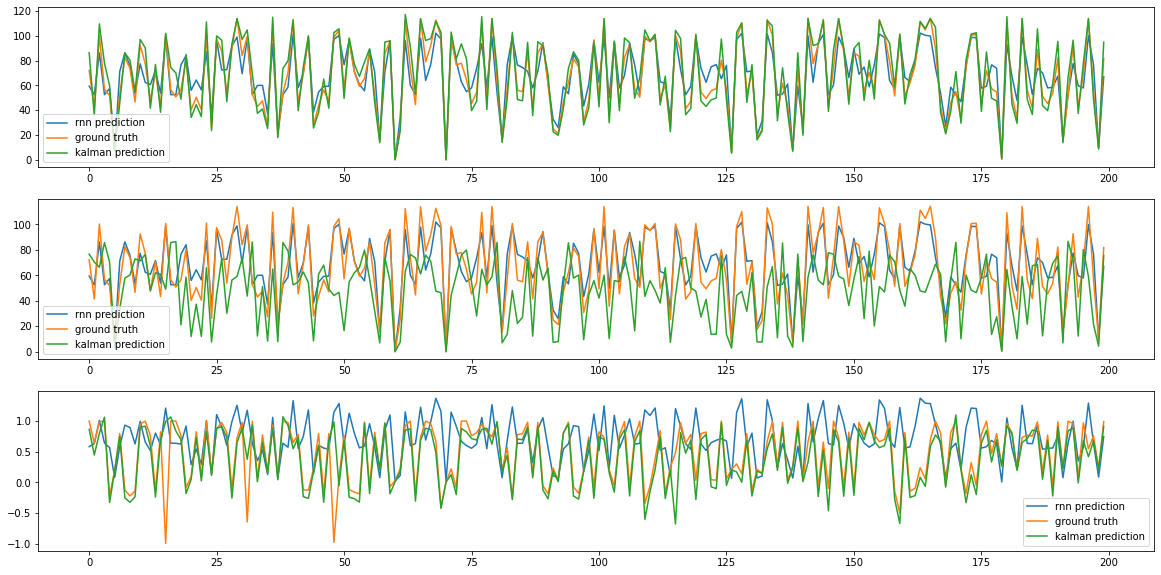

In [88]:
# kf_pred = torch.tensor(test_df['kalman prediction'].to_list()).reshape(-1, 1)
# gt = torch.tensor(test_df['ground truth'].to_list()).reshape(-1, 1)

# gt.shape, kf_pred.shape

split = 200


plt.figure(figsize=(20, 10))

plt.subplot(3, 1, 1)
plt.plot(test_pred_x[:split])
plt.plot(test_output_x[:split])
plt.plot(kalman_pred_x[:split])
plt.legend(['rnn prediction', 'ground truth', 'kalman prediction'])


plt.subplot(3, 1, 2)
plt.plot(test_pred_y[:split])
plt.plot(test_output_y[:split])
plt.plot(kalman_pred_y[:split])
plt.legend(['rnn prediction', 'ground truth', 'kalman prediction'])

plt.subplot(3, 1, 3)
plt.plot(test_pred_theta[:split])
plt.plot(test_output_theta[:split])
plt.plot(kalman_pred_theta[:split])
plt.legend(['rnn prediction', 'ground truth', 'kalman prediction'])



# plt.figure(figsize=(20, 10))

# plt.subplot(3, 1, 1)
# plt.plot(test_pred_x[:split])
# plt.plot(test_output_x[:split])

# plt.legend(['rnn prediction', 'ground truth'])

# plt.subplot(3, 1, 2)
# plt.plot(test_pred_y[:split])
# plt.plot(test_output_y[:split])
# plt.legend(['rnn prediction', 'ground truth'])

# plt.subplot(3, 1, 3)
# plt.plot(test_pred_theta[:split])
# plt.plot(test_output_theta[:split])
# plt.legend(['rnn prediction', 'ground truth'])

# plt.subplot(4, 1, 4)

# # plt.plot(kl_test[:split])
# plt.plot(test_output[:split])
# plt.plot(test_pred.detach().cpu()[:split])

# plt.legend(['kalman prediction', 'ground truth', 'rnn prediction'])
# # plt.legend(['ground truth', 'rnn prediction'])
# # plt.plot(pred.to_list())



In [62]:
def save_checkpoint(checkpoint):
    model_save_dir = f'./results/{CSV_NAME}'
    # print(model_save_dir)
    os.makedirs(model_save_dir, exist_ok=True)

    # chckpoint = {
    #     'epoch': num_epochs,
    #     'model_state_dict': model.state_dict(),
    #     'optimizer_state_dict': optimizer.state_dict(),
    #     'loss': torch.tensor(loss_cache),
    # }

    torch.save(checkpoint, os.path.join(model_save_dir, "model.pt"))